# Report of AUTDMC

AUTDMC was an online competition to predict the number of tickets that [Alibaba.ir](www.alibaba.ir) sales in each day. 

-----------------------------

## Code

#### Importing Libraries and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm
import seaborn as sns
%matplotlib inline

# UNCOMMENT THE CODES BELOW FOR INTERACTIVE PLOTS

#from plotly.offline import download_plotlyjs,init_notebook_mode,iplot
#import cufflinks as cf
#init_notebook_mode(connected=True)
#cf.go_offline()
#cf.set_config_file(offline=True)

In [3]:
data=pd.read_csv('data.csv')
test=pd.read_csv('test.csv')
data.dropna(inplace=True)

#### Pre-Proccessing

In [4]:
data['FROM']=data['FROM'].apply(int)
data['TO']=data['TO'].apply(int)
test.columns=['Log_Date', 'FROM', 'TO', 'Sales']

In [5]:
dow5=[1,4,0,3,6,2,5,0,2,4,6,1]
dow6=[3,6,2,5,1,4,0,2,4,6,1,3]
dow7=[4,0,3,6,2,5,1,3,5,0,2,4]
dow=[dow5,dow6,dow7]

def dow_calc(s):
    arr=dow[int(s[3])-5]
    month=int(s[5:7])
    day=int(s[-2:])
    return (arr[month-1]+day-1)%7

In [6]:
%%time
for df in [data,test]:
    df['Date']=df['Log_Date'].apply(lambda x: x[-5:])
    df['Year']=df['Log_Date'].apply(lambda x: int(x[3]))
    df['Month']=df['Log_Date'].apply(lambda x: int(x[-5:-3]))
    df['Month_cont']=df['Month']+(df['Year']-5)*12
    df['Day']=df['Log_Date'].apply(lambda x: int(x[-2:]))
    df['DOW']=df['Log_Date'].apply(dow_calc)
    df['Dir']=df.apply(lambda x: str(x['FROM'])+','+str(x['TO']),axis=1)
    df['Zip']=df.apply(lambda x: x['Log_Date']+':'+x['Dir'],axis=1)

Wall time: 2min 28s


In [7]:
gbdf=pd.DataFrame(data.groupby('Zip').size(),columns=['Val'])
gbdf.reset_index(inplace=True)
gbdf['Date']=gbdf['Zip'].apply(lambda x:x.split(':')[0])
gbdf['Dir']=gbdf['Zip'].apply(lambda x:x.split(':')[1])

In [8]:
gbdf.head()

,Zip,Val,Date,Dir
0,"1395/01/02:10,11",6,1395/01/02,"10,11"
1,"1395/01/02:10,15",1,1395/01/02,"10,15"
2,"1395/01/02:10,30",11,1395/01/02,"10,30"
3,"1395/01/02:10,49",1,1395/01/02,"10,49"
4,"1395/01/02:10,66",1,1395/01/02,"10,66"


In [9]:
gbdf_gb=pd.DataFrame(gbdf.groupby('Dir')['Val'].size(),columns=['Size'])
gbdf_gb=pd.DataFrame(gbdf.groupby('Dir').size(),columns=['Days'])
gbdf_gb['Min']=gbdf.groupby('Dir')['Val'].min()
gbdf_gb['Mean']=gbdf.groupby('Dir')['Val'].mean()
gbdf_gb['Median']=gbdf.groupby('Dir')['Val'].median()
gbdf_gb['Max']=gbdf.groupby('Dir')['Val'].max()
gbdf_gb['Std']=gbdf.groupby('Dir')['Val'].std()

gbdf_gb.reset_index(inplace=True)

In [10]:
gbdf_gb.head()

,Dir,Days,Min,Mean,Median,Max,Std
0,"1,49",71,1,1.704225,1.0,5,1.126237
1,"1,56",148,1,1.263514,1.0,5,0.632041
2,"1,70",1,1,1.000000,1.0,1,NaN
3,"10,11",450,1,2.171111,2.0,9,1.463608
4,"10,15",636,1,3.976415,3.0,20,3.034875


In [11]:
data=data.merge(gbdf.drop('Dir',axis=1),how='left',on='Zip')
data=data.merge(gbdf_gb,how='left',on='Dir')
data.drop(['Log_Time', 'Log_Date', 'AL', 'FROM', 'TO', 'Departure_Time','Departure_Date', 'Price'],axis=1,inplace=True)
data.head()

,Date_x,Year,Month,Month_cont,Day,DOW,Dir,Zip,Val,Date_y,Days,Min,Mean,Median,Max,Std
0,09/21,5,9,9,21,1,"70,15","1395/09/21:70,15",65,1395/09/21,730,6,57.650685,48.0,197,36.440867
1,05/01,5,5,5,1,6,"10,70","1395/05/01:10,70",53,1395/05/01,730,24,144.478082,131.0,350,66.794221
2,10/08,6,10,22,8,6,"3,70","1396/10/08:3,70",14,1396/10/08,730,2,22.752055,19.0,74,13.465096
3,04/07,5,4,4,7,2,"75,70","1395/04/07:75,70",12,1395/04/07,730,2,26.538356,24.0,70,14.156747
4,04/07,5,4,4,7,2,"75,70","1395/04/07:75,70",12,1395/04/07,730,2,26.538356,24.0,70,14.156747


In [12]:
test=test.merge(gbdf_gb,how='left',on='Dir')
test.drop(['Log_Date', 'FROM', 'TO','Sales'],axis=1,inplace=True)
test.fillna(0,inplace=True)
test.head()

,Date,Year,Month,Month_cont,Day,DOW,Dir,Zip,Days,Min,Mean,Median,Max,Std
0,01/01,7,1,25,1,4,"3,30","1397/01/01:3,30",671.0,1.0,4.061103,4.0,16.0,2.745008
1,01/01,7,1,25,1,4,"3,49","1397/01/01:3,49",634.0,1.0,4.421136,4.0,21.0,3.219352
2,01/01,7,1,25,1,4,"3,66","1397/01/01:3,66",694.0,1.0,4.361671,4.0,15.0,2.704339
3,01/01,7,1,25,1,4,"3,70","1397/01/01:3,70",730.0,2.0,22.752055,19.0,74.0,13.465096
4,01/01,7,1,25,1,4,"4,70","1397/01/01:4,70",39.0,1.0,1.769231,1.0,5.0,1.037749


#### Training Model

In [12]:
trcols=['DOW', 'Min', 'Mean', 'Median', 'Max', 'Std','Month_cont']
skew=15
n_est=75
shift=1.1

In [13]:
def myeval(y_true,y_pred):
    diff=(y_true-y_pred)
    grad=np.where(diff<0,-2*skew*diff,-2.0*diff)
    hess=np.where(diff<0,2*skew,2.0)
    return grad , hess

In [14]:
lgr=lightgbm.LGBMRegressor(n_estimators=n_est,objective=myeval)
train=data.sample(frac=1)
lgr.fit(train[trcols],train['Val'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=75, n_jobs=-1, num_leaves=31,
       objective=<function myeval at 0x0000001C3E3D5B70>,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
raw_pred=lgr.predict(test[trcols])
pred=raw_pred-shift
pred=np.floor(pred)
pred[pred<1]=1

In [16]:
np.histogram(pred,range(400))[0][:10]

array([   0, 4559, 1346,  500,  702,  144,  100,   60,  259,   84],
      dtype=int64)

#### Submission

In [17]:
sub=pd.read_csv('test.csv')

In [18]:
sub['Sales']=pred
sub['Sales']=sub['Sales'].apply(int)
sub.to_csv('bd{}_{}.csv'.format(skew,n_est),index=False)
sub.head()

,Log_Date,From,To,Sales
0,1397/01/01,3,30,4
1,1397/01/01,3,49,4
2,1397/01/01,3,66,4
3,1397/01/01,3,70,36
4,1397/01/01,4,70,1


---------------------

# Exploratary Data Analaysis

The main idea beside the algorithm is to translate each *direction=(From,To)* to some quantitive values. I just use some simple **statitistics of direction** ( min, median, std,...) for model training together with **day of week** of *Log_Data* and a **continuous version of month**. I have tried some other features like *official holidays, day of month, day of year,...* but they were not so useful. I will be trying to justify that in a short while.

####  Let's start with some simple EDA.

Let's pick a direction to work with. For example from 10 to 70 (probably Kish to Tehran)

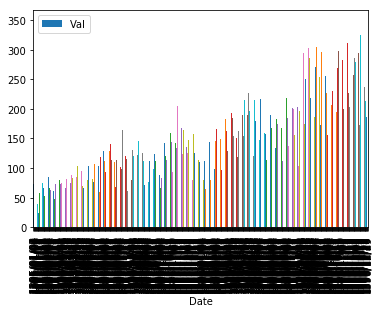

In [14]:
FROM=10
TO=70
df=gbdf[gbdf['Dir']=='{},{}'.format(FROM,TO)]
df.plot(kind='bar',x='Date',y='Val')

#df.iplot(kind='bar',x='Date',y='Val')

We may see a trivial increasing trend towards the time but there is some periodic drops where suggest to invest on day of week. I will come back to this but for a moment let's plot the whole trends in one plot.

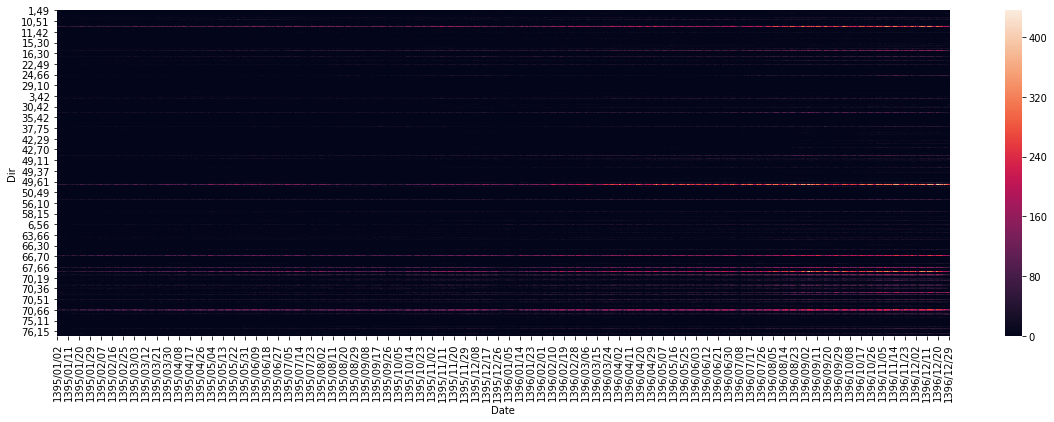

In [20]:
plt.figure(figsize=(20,6))
heat_df=gbdf.groupby(['Dir','Date'])['Val'].mean().unstack().fillna(0)
_=sns.heatmap(heat_df)

The increasing pattern is visible in this plot as well. In addition you may notice the regular drops of period 7 days. To have a more smooth plot of the trend we plot the number of flights in each month for both years 1395 and 1396.

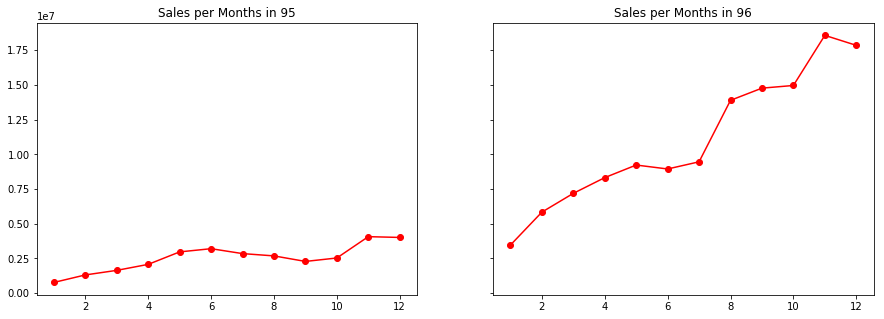

In [21]:
data95=data[data['Year']==5]
data96=data[data['Year']==6]
Month95=data95.groupby('Month')['Val'].sum()
Month96=data96.groupby('Month')['Val'].sum()
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(15,5),sharey=True)
ax1.plot(Month95,'ro-')
ax1.set_title('Sales per Months in 95')
ax2.plot(Month96,'ro-')
_=ax2.set_title('Sales per Months in 96')

The plots above suggest to use some continuous version of month. It will give you a parameter to predict the speed of the progress of the company. You may notice two jumps in 8th and 11th months of 96 which may be caused by some effective advertisment or may be some discounts. Let's plot an interactive graph with continuous version of month.

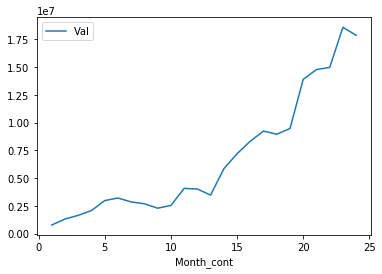

In [15]:
pd.DataFrame(data.groupby('Month_cont')['Val'].sum()).plot()

#pd.DataFrame(data.groupby('Month_cont')['Val'].sum()).iplot()

I have myself plotted some other features as well but they were not much informative. So I decided to omit them to avoid curse of dimentions and over fitting.

----------------------

# Evalution Function Analysis

I believe MAPE is not the best choice for evalution in this problem cause it is more sensitive to small values, but probably the larger values are more important for the company. Anyway, I had to investigate this function. First of all, I found an interesting formula about MAPE.

let
$$$$
$$f(x)=MAPE(y_{true},x)$$
$$$$
be a real function. Using some elementary calculations one may prove that for $i\in \mathbb{N}$:
$$$$
$$\frac{f(i+1)+f(i-1)}{2}-f(i)=\frac{n_i}{in}$$
$$$$
where $n$ is the size of test set and $n_i$ is the number of test cases with $y_{true}=i$. As small values are crucial for the evaluting function I have tried predicting *all one* , *all two*, *all three* and *all four* predictions to calculate $n_1,n_2,n_3$. Note that $f(0)=1$ trivially. Here are the other values:

x|f(x)|n_i/in|n_i
--|--|--|--
0|1||
1|0.65|0.2|2323
2|0.7|0.065|1510
3|0.88|0.03|1045
4|1.12||

It gives you an intution about the test set. These all together suggest you to use some non-symmetric regressor. I have used Lightgbm with custom objective function. I gave 10 times more penalty for over estimation compared to underestimation. On the other hand to avoid over training I stop the procedure after 100 steps and shift the prediction by 1. You may tune these hyper parameter to get better results.

**Remark : ** I tried some ensemble methods to achieve my best result, but I preferred to avoid explaining them in the sake of simplicity. 